# 初心者分析講座2より

特徴量作成とparameterを追う感じ？

In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style('ticks')

In [2]:
INPUT_DIR = '../data/inputs/'
OUTPUT_DIR = '../data/outputs/'

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [3]:
train_df = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))
test_df = pd.read_csv(os.path.join(INPUT_DIR, 'test.csv'))
whole_df = pd.concat([train_df, test_df], ignore_index=True)

In [4]:
train_df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,LEGO Batman: The Videogame,Wii,NaN,Action,Warner Bros. Interactive Entertainment,180,97,0,28,306,74.0,17.0,7.9,22.0,Traveller's Tales,E10+
1,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,LucasArts,151,61,0,21,234,78.0,22.0,6.6,28.0,Traveller's Tales,E10+
2,LEGO Batman: The Videogame,PSP,NaN,Action,Warner Bros. Interactive Entertainment,56,44,0,27,128,73.0,5.0,7.4,10.0,Traveller's Tales,E10+
3,Combat,2600,NaN,Action,Atari,117,7,0,1,125,NaN,NaN,NaN,NaN,NaN,NaN
4,LEGO Harry Potter: Years 5-7,Wii,NaN,Action,Warner Bros. Interactive Entertainment,69,42,0,12,124,76.0,8.0,7.8,13.0,Traveller's Tales,E10+


In [5]:
test_df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Hitman 2: Silent Assassin,XB,NaN,Action,Eidos Interactive,84.0,23.0,8,19.0,Io Interactive,M
1,Legacy of Kain: Soul Reaver,PS,NaN,Action,Eidos Interactive,91.0,17.0,9,132.0,Crystal Dynamics,T
2,Metal Gear Solid 2: Substance,XB,NaN,Action,Konami Digital Entertainment,87.0,28.0,8.5,39.0,KCEJ,M
3,Silent Hill: Homecoming,X360,NaN,Action,Konami Digital Entertainment,70.0,54.0,6.9,180.0,Double Helix Games,M
4,Silent Hill: Homecoming,PS3,NaN,Action,Konami Digital Entertainment,71.0,41.0,6.9,143.0,Double Helix Games,M


In [6]:
# name、publicher、developerの情報は落とすかうまいこと使いたい

In [7]:
# tbdの処理でNoneにする
def preprocess(input_df: pd.DataFrame) -> pd.DataFrame:
    output_df = input_df.copy()
    
    idx_tbd = input_df['User_Score'] == 'tbd'
    output_df['User_Score_is_tbd'] = idx_tbd.astype(int)
    
    output_df['User_Score'] = input_df['User_Score'].replace('tbd', None).astype(float)
    return output_df

# 連続変数のコピー
def create_continuous_features(input_df):
    input_df = preprocess(input_df)
    use_columns = [
        # 連続変数
        'Critic_Score',
        'Critic_Count', 
        'User_Score', 
        'User_Count',
        'Year_of_Release',
        'User_Score_is_tbd'
    ]
    return input_df[use_columns].copy()

In [8]:
train_df['Developer']

0                Traveller's Tales
1                Traveller's Tales
2                Traveller's Tales
3                              NaN
4                Traveller's Tales
                   ...            
8354    Paradox Development Studio
8355                           NaN
8356                           NaN
8357                           NaN
8358                           NaN
Name: Developer, Length: 8359, dtype: object

In [9]:
def create_boolean_feature(input_df):
    output_df = pd.DataFrame()
    
    texts = [
        'japan', 'nintendo'
    ]
    
    for t in texts:
        output_df[f'Developer_has_{t}'] = input_df['Developer'].fillna('').str.lower().str.contains(t).astype(int)
    return output_df

In [10]:
create_boolean_feature(train_df).sum()

Developer_has_japan       23
Developer_has_nintendo    88
dtype: int64

特徴量生成

In [11]:
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)
        
    def transform(self, input_df):
        raise NotImplementedError()

In [12]:
# countEncodign
class CountEncodingBlock(BaseBlock):
    def __init__(self, column, whole_df: pd.DataFrame):
        self.column = column
        self.whole_df = whole_df

    def transform(self, input_df):
        output_df = pd.DataFrame()
        c = self.column
        
        vc = self.whole_df[c].value_counts()
        output_df[c] = input_df[c].map(vc)
        return output_df.add_prefix('CE_')

In [13]:
class OneHotBlock(BaseBlock):
    def __init__(self, column: str):
        self.column = column
        self.cats_ = None
        
    def fit(self, input_df, y=None):
        vc = input_df[self.column].dropna().value_counts()
        cats = vc[vc > 40].index
        self.cats_ = cats
        return self.transform(input_df)
    
    def transform(self, input_df):
        x = pd.Categorical(input_df[self.column], categories=self.cats_)
        out_df = pd.get_dummies(x, dummy_na=False)
        out_df.columns = out_df.columns.tolist()
        return out_df.add_prefix(f'OH_{self.column}=')

In [14]:
import texthero as hero
from texthero import preprocessing

In [15]:
custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                   , preprocessing.remove_digits
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_whitespace
                   , preprocessing.remove_stopwords
                  ]

In [16]:
from nltk.util import ngrams

def line_ngram(line, n=2):
    words = [w for w in line.split(' ') if len(w) != 0] # 空文字は取り除く
    return list(ngrams(words, n))

In [17]:
def clearn_by_hero(x):
    custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                   , preprocessing.remove_digits
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_whitespace
                   , preprocessing.remove_stopwords
                  ]
    return hero.clean(x, custom_pipeline)

def create_n_gram(x, n=3):
    x = clearn_by_hero(x)
    x = pd.Series(x).map(lambda r: line_ngram(r, n=n))
    return x

class NameNGramBlock(BaseBlock):
    def __init__(self, whole_df, n=3):
        self.whole_df = whole_df
        self.n = n
    
    def fit(self, input_df, y=None):
        name_grams = create_n_gram(self.whole_df['Name'], n=self.n)
        grams = [x for row in name_grams for x in row if len(x) > 0]
        top_grams = pd.Series(grams).value_counts().head(20).index
        
        self.top_grams_ = top_grams
        return self.transform(input_df)
    
    def transform(self, input_df):
        name_grams = create_n_gram(input_df['Name'], n=self.n)
        output_df = pd.DataFrame()
        
        for top in self.top_grams_:
            s_top = '-'.join(top)
            output_df[f'{s_top}'] = name_grams.map(lambda x: top in x).map(int)

        return output_df.add_prefix('Name_has_').add_suffix(f'_n={self.n}')

In [18]:
sales_columns = train_df.columns[train_df.columns.str.contains('Sales')].tolist()
sales_columns = sorted(sales_columns)

class SalesPortfolioBlock(BaseBlock):
    """売上ポートフォリオ"""
    
    def __init__(self, key: str):
        self.key = key    
        self.meta_df = None
    
    def fit(self, input_df):
        _df = input_df[sales_columns].groupby(input_df[self.key]).sum()
        _df = (_df.T / _df.sum(axis=1)).T
        self.meta_df = _df
        return self.transform(input_df)
    
    def transform(self, input_df):
        out_df = pd.merge(input_df[self.key], self.meta_df, on=self.key, how='left').drop(columns=[self.key])
        out_df = out_df.add_prefix(f'SP@{self.key}_')
        return out_df

In [19]:
class WrapperBlock(BaseBlock):
    def __init__(self, function):
        self.function = function
        
    def transform(self, input_df):
        return self.function(input_df)

In [20]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from contextlib import contextmanager
from time import time

@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [21]:
process_blocks = [
    WrapperBlock(create_continuous_features),
    WrapperBlock(create_boolean_feature),
    NameNGramBlock(whole_df, n=3),
    *[OneHotBlock(c) for c in ['Platform', 'Genre', 'Publisher', 'Rating']],
    *[CountEncodingBlock(c, whole_df=whole_df) for c in ['Name', 'Platform', 'Year_of_Release']],
    *[SalesPortfolioBlock(c) for c in ['Genre']]
]

In [22]:
process_blocks

In [23]:
from tqdm import tqdm


def get_function(block, is_train):
    s = mapping = {
        True: 'fit',
        False: 'transform'
    }.get(is_train)
    return getattr(block, s)
    

def to_feature(input_df, 
               blocks,
               is_train=False):
    out_df = pd.DataFrame()
    
    for block in tqdm(blocks, total=len(blocks)):
        func = get_function(block, is_train)
        
        with timer(prefix='create ' + str(block) + ' '):
            _df = func(input_df)
        
        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [24]:
train_feat_df = to_feature(train_df, process_blocks, is_train=True)
test_feat_df = to_feature(test_df, process_blocks)

  0%|          | 0/11 [00:00<?, ?it/s]create <__main__.WrapperBlock object at 0x11fadbaf0> 0.014[s]
create <__main__.WrapperBlock object at 0x11fadb850> 0.025[s]
  0%|          | 0/11 [00:00<?, ?it/s]create <__main__.NameNGramBlock object at 0x11fadb700> 0.620[s]
create <__main__.OneHotBlock object at 0x11fadbca0> 0.007[s]
create <__main__.OneHotBlock object at 0x1257b7820> 0.004[s]
create <__main__.OneHotBlock object at 0x1257b7490> 0.005[s]
create <__main__.OneHotBlock object at 0x1257b70d0> 0.004[s]
create <__main__.CountEncodingBlock object at 0x1257b71c0> 0.010[s]
create <__main__.CountEncodingBlock object at 0x1257b7100> 0.005[s]
create <__main__.CountEncodingBlock object at 0x1257b7340> 0.003[s]
create <__main__.SalesPortfolioBlock object at 0x1257b7400> 0.011[s]
create <__main__.WrapperBlock object at 0x11fadbaf0> 0.007[s]
create <__main__.WrapperBlock object at 0x11fadb850> 0.021[s]
100%|██████████| 11/11 [00:00<00:00, 25.09it/s]create <__main__.NameNGramBlock object at 0x11fa

# LightGBMによる学習

In [27]:
import lightgbm as lgbm
import xgboost as xgb

from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

def fit_lgbm(X, 
             y, 
             cv, 
             params: dict=None, 
             verbose: int=50):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""
    metric_func = mean_squared_error
    
    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    # training data の target と同じだけのゼロ配列を用意
    # float にしないと悲しい事件が起こるのでそこだけ注意
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)
        
        with timer(prefix='fit fold={} '.format(i + 1)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=verbose,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)
        
        oof_pred[idx_valid] = pred_i
        models.append(clf)

        print(f'Fold {i} RMSLE: {metric_func(y_valid, pred_i) ** .5:.4f}')

    score = metric_func(y, oof_pred) ** .5
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [28]:
params = {
    'objective': 'rmse', # 目的関数. これの意味で最小となるようなパラメータを探します. 
    'learning_rate': .1, # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、がそれだけ木を作るため学習に時間がかかります
    'max_depth': 6, # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
    'n_estimators': 10000, # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    'colsample_bytree': .5, # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
    'importance_type': 'gain' # 特徴重要度計算のロジック(後述)
}

y = train_df['Global_Sales'].values
y = np.log1p(y) # log + plus1 変換する

In [29]:
from sklearn.model_selection import KFold, GroupKFold

fold = KFold(n_splits=5, shuffle=True, random_state=71)
cv = list(fold.split(train_feat_df, y)) # もともとが generator なため明示的に list に変換する

In [30]:
oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 0.929584
[100]	valid_0's rmse: 0.902337
[150]	valid_0's rmse: 0.894639
[200]	valid_0's rmse: 0.891116
[250]	valid_0's rmse: 0.888751
[300]	valid_0's rmse: 0.887609
[350]	valid_0's rmse: 0.887002
[400]	valid_0's rmse: 0.886242
[450]	valid_0's rmse: 0.887273
Early stopping, best iteration is:
[419]	valid_0's rmse: 0.885586
fit fold=1 0.602[s]
Fold 0 RMSLE: 0.8856
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 0.945063
[100]	valid_0's rmse: 0.916393
[150]	valid_0's rmse: 0.903928
[200]	valid_0's rmse: 0.896618
[250]	valid_0's rmse: 0.891332
[300]	valid_0's rmse: 0.888026
[350]	valid_0's rmse: 0.887259
[400]	valid_0's r

In [31]:
# Group KFold
def split_by_groups(groups):
    kfold = KFold(n_splits=10, random_state=71, shuffle=True)
    groups = pd.Series(groups)
    
    unique_groups = groups.unique()
    splits = []
    
    def _filter_ids(idx):
        values = unique_groups[idx]
        idx = groups.isin(values)
        return groups[idx].index.values
    
    for idx_tr, idx_val in kfold.split(unique_groups):
        splits.append([
            _filter_ids(idx_tr), _filter_ids(idx_val)
        ])
        
    return splits

In [32]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.
    
    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

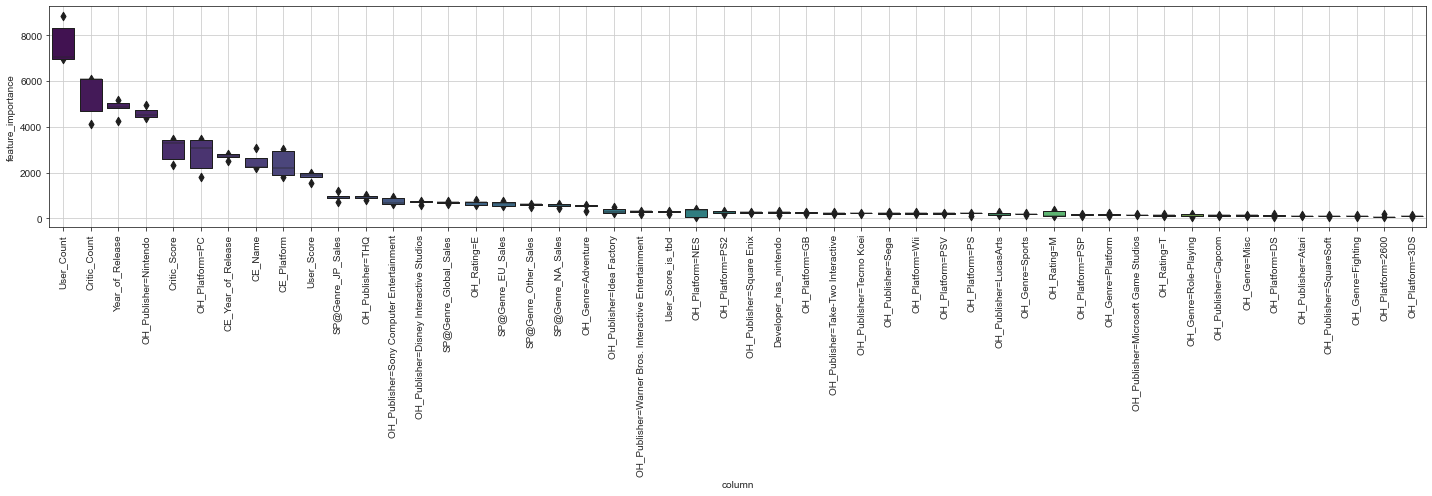

In [33]:
fig, ax = visualize_importance(models, train_feat_df)

In [34]:
pred = np.array([model.predict(test_feat_df.values) for model in models])
pred = np.mean(pred, axis=0)
pred = np.expm1(pred)
pred = np.where(pred < 0, 0, pred)
sub_df = pd.DataFrame({ 'Global_Sales': pred })
sub_df.to_csv(os.path.join(OUTPUT_DIR, 'simple_submission2.csv'), index=False)

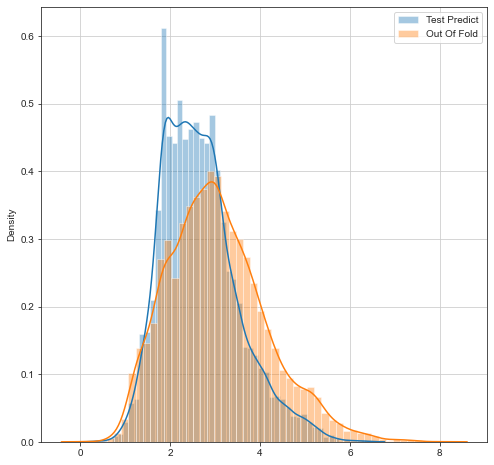

In [35]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.distplot(np.log1p(pred), label='Test Predict')
sns.distplot(oof, label='Out Of Fold')
ax.legend()
ax.grid()